![Instituto Politécnico de Leiria](https://www.ipleiria.pt/wp-content/webpc-passthru.php?src=https://www.ipleiria.pt/wp-content/uploads/2021/10/estg_h-01.png&nocache=1)

<center>

# AI Driving Classification  <span style="font-size: 14px;">2023/2024</span>


<div align="center" style="font-weight: bold">Team Members:</div>

<div align="center">Alberto Manuel de Matos Pingo - 2202145</div>

<div align="center">João Pedro Quintela de Castro - 2201781</div>

---

## **Second Approach - Bidirectional LSTM**

</center>

---

## Directories

In [1]:
import os

# Make auxiliar folders
if not os.path.exists('runtime_saves'):
    os.makedirs('runtime_saves')
if not os.path.exists('runtime_saves/models'):
    os.makedirs('runtime_saves/models')
if not os.path.exists('runtime_saves/train&test'):
    os.makedirs('runtime_saves/train&test')
    
current_dir = os.getcwd()

root_dir = os.path.abspath(os.path.join(current_dir, os.pardir, os.pardir))

datasets_dir = os.path.join(root_dir, 'datasets')

dataset_dir = os.path.join(datasets_dir, 'IPL-Dataset')


print(f'Root directory: {root_dir}')
print(f'Datasets directory: {datasets_dir}')
print(f'Dataset directory: {dataset_dir}')

Root directory: /home/pws/code/CoEProject-AI-DrivingClassification
Datasets directory: /home/pws/code/CoEProject-AI-DrivingClassification/datasets
Dataset directory: /home/pws/code/CoEProject-AI-DrivingClassification/datasets/IPL-Dataset


# **DATA PREPROCESSING**

## Data Structure

Accelerometer (m/s²): Acceleration along the each axis.
- **accelerometerXAxis**
- **accelerometerZAxis**
- **accelerometerYAxis**

Gyroscope (°/s): Angular velocity along the each axis.
- **gyroscopeXAxis**
- **gyroscopeYAxis**
- **gyroscopeZAxis**

GPS Coordinates (°): 
- **Latitude**
- **Longitude**

## Load Scenarios and Data Cleaning

In [2]:
import json
import pandas as pd
import numpy as np

directories = ['Acceleration', 'Brake', 'Intersection']
column_names = ['accelerometerXAxis', 'accelerometerYAxis', 'accelerometerZAxis', 'gyroscopeXAxis', 'gyroscopeYAxis', 'gyroscopeZAxis', 'Latitude', 'Longitude']
label_names = ['Slow', 'Normal', 'Aggressive']

df_bmw = pd.DataFrame(columns=column_names)
labels_bmw = []
df_honda = pd.DataFrame(columns=column_names)
labels_honda = []

data_bmw_list = []
data_honda_list = []

for directory in directories:
    for root, dirs, files in os.walk(os.path.join(dataset_dir, directory)):
        if 'turn 90 degree constant speed' in root: # Skip this directory
            continue
        for file in files:
            if file.endswith('.json'):
                f_car = os.path.basename(root).split()[0].upper()            
                f_label = os.path.basename(os.path.dirname(root))
                
                f_data = json.load(open(os.path.join(root, file)))
                f_data = f_data['capturedData']
                f_data = pd.DataFrame(f_data)
                
                f_data = f_data[column_names]
                
                # Add Label to each row
                f_labels = np.full((f_data.shape[0]), f_label)
                                
                if f_car == 'BMW':                                      
                    data_bmw_list.append(f_data.copy())
                    labels_bmw.extend(f_labels)                    
                elif f_car == 'HONDA':
                    data_honda_list.append(f_data.copy())
                    labels_honda.extend(f_labels)                    

label_names = np.unique(labels_bmw)

# Raw Data
df_bmw = pd.concat(data_bmw_list, axis=0)
df_honda = pd.concat(data_honda_list, axis=0)
# Save Data to CSV - runtime_saves folder
df_bmw.to_csv('runtime_saves/00BMW_raw.csv', index=False)
df_honda.to_csv('runtime_saves/00HONDA_raw.csv', index=False)

# Labels
labels_bmw = np.array(labels_bmw)
labels_honda = np.array(labels_honda)
labels = np.concatenate((labels_bmw, labels_honda))
# Save Labels to CSV - runtime_saves folder
np.savetxt('runtime_saves/BMW_labels.csv', labels_bmw, delimiter=',', fmt='%s')
np.savetxt('runtime_saves/HONDA_labels.csv', labels_honda, delimiter=',', fmt='%s')

## Rolling Window

This processes **reduces the sensor data noise** by applying a centered rolling mean with a window of 3 to each column of the DataFrame. \
For each value, the function computes the mean of the current value, the one before, and the one after.

    Applied to each scenario individually.

In [3]:
def apply_rolling_window(df):
    df = df.rolling(window=3, center=True, min_periods=1).mean()   
     
    return df

columns_to_process = ['accelerometerXAxis', 'accelerometerYAxis', 'accelerometerZAxis', 'gyroscopeXAxis', 'gyroscopeYAxis', 'gyroscopeZAxis']

for i in range(len(data_bmw_list)):
    data_bmw_list[i][columns_to_process] = apply_rolling_window(data_bmw_list[i][columns_to_process].copy())
for i in range(len(data_honda_list)):
    data_honda_list[i][columns_to_process] = apply_rolling_window(data_honda_list[i][columns_to_process].copy())

data_bmw = pd.concat(data_bmw_list, axis=0)
data_honda = pd.concat(data_honda_list, axis=0)

# Save Data to CSV - runtime_saves folder
data_bmw.to_csv('runtime_saves/01BMW_rollingwindow.csv', index=False)
data_honda.to_csv('runtime_saves/01HONDA_rollingwindow.csv', index=False)

In [4]:
# import numpy as np
# import pandas as pd

# # Load the dataset into a DataFrame
# df_bmw = pd.read_csv('runtime_saves/01BMW_rollingwindow.csv')
# df_honda = pd.read_csv('runtime_saves/01HONDA_rollingwindow.csv')

# # Load the labels into a NumPy array
# labels_bmw = np.loadtxt('runtime_saves/bmw_labels.csv', delimiter=',', dtype=str)
# labels_honda = np.loadtxt('runtime_saves/honda_labels.csv', delimiter=',', dtype=str)

## Statistics - Label Distribution

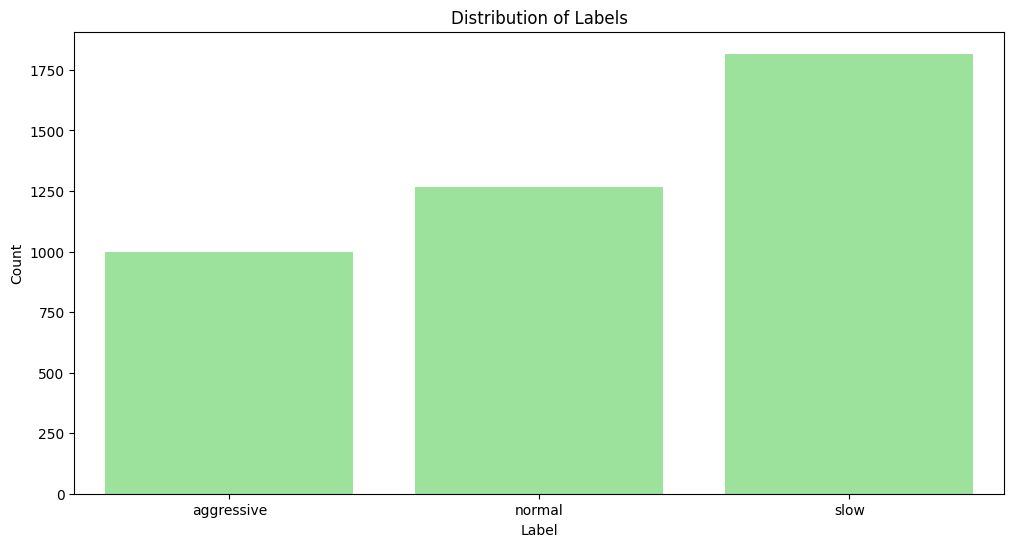

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = pd.Series(labels)

# plot the count of each label
plt.figure(figsize=(12, 6))
sns.countplot(x=labels, color='lightgreen')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Label Encoding

This process encodes each unique Categorical label as a distinct integer.

In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

labels = label_encoder.fit_transform(labels)

## Normalize Data

This process **helps the model performance** by rescaling specified columns of the dataset to a range between 0 and 1, based on the minimum and maximum values of that column.
    
    Applied to each car individually.

In [7]:
def normalize_between_0_and_1(data, columns):
    for column in columns:
        if column not in data.columns:
            print(f"[WARNING] {column} not found in DataFrame.")
            continue
        else:
            max_value = np.max(data[column])
            min_value = np.min(data[column])
            data[column] = (data[column] - min_value) / (max_value - min_value)
    return data

columns_to_normalize = ['accelerometerXAxis', 'accelerometerYAxis', 'accelerometerZAxis', 'gyroscopeXAxis', 'gyroscopeYAxis', 'gyroscopeZAxis']


df_bmw = normalize_between_0_and_1(df_bmw, columns_to_normalize)
df_honda = normalize_between_0_and_1(df_honda, columns_to_normalize)

## Concatenate Data

This process concatenates all cars into a single DataFrame after applyting the rolling window and normalization.

In [8]:
df = pd.concat([df_bmw, df_honda], axis=0)

# create label column in the dataframe
df['label'] = labels

## Create Sequences

This process involves segmenting time-series data into overlapping sequences and associating each sequence with a label based on the most frequent label within that window.

In [9]:
import numpy as np
from scipy.stats import mode

def create_sequences(data, labels, window_size=16, step_size=2):
    X, y = [], []
    for i in range(0, len(data) - window_size + 1, step_size):
        # Create the window of data
        X.append(data[i:i + window_size].values)        
        
         # Find the most frequent string label in the current window
        window_labels = labels[i:i + window_size]
        most_frequent_label = mode(window_labels, axis=None)[0]
        
        # Add the most frequent label as the label of the current window
        y.append(most_frequent_label)
            
    return np.array(X), np.array(y)

time_steps = 16
step_size = 1

X, y = create_sequences(
    df[['accelerometerXAxis', 'accelerometerYAxis', 'accelerometerZAxis',
        'gyroscopeXAxis', 'gyroscopeYAxis', 'gyroscopeZAxis', 
        'Latitude', 'Longitude']],
    df['label'],
    window_size=time_steps,
    step_size=step_size    
)

# Save Features and Labels
np.save('runtime_saves/X.npy', X)
np.savetxt('runtime_saves/y.csv', y, delimiter=',', fmt='%d')

# Split Dataset for Model Training

This section splits the dataset into training, test, and validation sets

- 70% Training
- 20% Test
- 10% Validation

Stratify ensures each set maintains the original class distribution, while shuffle randomizes data to avoid any biases.

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=23)

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, stratify=y_train, random_state=23)


print(f'Train Info: {X_train.shape}, {y_train.shape}')
print(f'Test Info: {X_test.shape}, {y_test.shape}')
print(f'Validation Info: {X_validation.shape}, {y_validation.shape}')

Train Info: (2927, 16, 8), (2927,)
Test Info: (814, 16, 8), (814,)
Validation Info: (326, 16, 8), (326,)


# **MODEL ARCHITECTURE** - Bidirectional LSTM

**Architecture:**

Input -> Bidirectional LSTM - BN -> Dropout -> Bidirectional LSTM - BN -> Dropout -> Bidirectional LSTM - BN -> Dropout -> Dense - Output

1. **Input Layer**
   - The input layer expects sequences with shape `(timesteps, features)`, where `timesteps` is the number of time steps and `features` is the number of features at each time step.
   - No specific preprocessing is applied to the input sequences beyond normalization.

2. **Bidirectional LSTM Layers**
   - The model contains three Bidirectional LSTM layers, each with 64 units.
   - The Bidirectional wrapper allows each LSTM to process sequences in both forward and backward directions, capturing dependencies from both sides of the sequence.
   - `return_sequences=True` is used for the first two LSTM layers to ensure that the output at each time step is returned, which is necessary for stacking multiple LSTM layers.

3. **Fully Connected (Dense) Layer**
   - A dense layer with 3 units and a softmax activation function is used as the output layer.
   - The softmax function outputs the probability distribution over the 3 classes.

**Overfitting Measures**
   - Dropout layers are utilized after each LSTM and dense layer to reduce the risk of overfitting by preventing the model from relying too heavily on any single feature or connection.

**Batch Normalization**
   - Batch normalization is used after each LSTM layer to normalize the activations, which helps in stabilizing and speeding up the training process by maintaining a consistent distribution of activations.

In [11]:
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional

# Inputs
input_shape = (X_train.shape[1], X_train.shape[2])
inputs = keras.Input(shape=input_shape)

# Architecture
x = Bidirectional(LSTM(64, return_sequences=True))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

outputs = Dense(3, activation='softmax')(x)

# Create the model
model = keras.Model(inputs=inputs, outputs=outputs)

2024-09-06 04:40:47.739258: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 04:40:47.739327: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 04:40:47.842423: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-06 04:40:48.054869: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-06 04:40:49.548582: W tensorflow/compiler/tf2

## Compile Model

**Loss function:** \
Use the *Sparse Categorical Crossentropy* loss function because it is a `multi-class classification` problem.

**Optimizer: RMSprop** \
Exploring the *Adam* optimizer.

In [12]:
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# import adam
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 8)]           0         
                                                                 
 bidirectional (Bidirection  (None, 16, 128)           37376     
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, 16, 128)           512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 16, 128)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 16, 128)           98816     
 onal)                                                           
                                                             

## Train Model

- 100 epochs
- Batch size of 16
- Early stopping
- Learning rate reduction on plateau
- Model checkpoint

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=7, 
    verbose=1, 
    factor=0.5, 
    min_lr=1e-8)

early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=12,
                           restore_best_weights=True)
model_checkpoint = ModelCheckpoint('runtime_saves/models/checkpoints/2A-BidirecionalLSTM-cp.keras', save_best_only=True)


history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_validation, y_validation),
    verbose=1,
    callbacks=[model_checkpoint, learning_rate_reduction])

Epoch 1/100


2024-09-06 04:41:01.899721: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-09-06 04:41:03.274865: I external/local_xla/xla/service/service.cc:168] XLA service 0x7313ac9ecc00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-06 04:41:03.274920: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2024-09-06 04:41:03.298414: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1725594063.404596    6752 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


183/183 [==============================] - 15s 22ms/step - loss: 1.4941 - accuracy: 0.3652 - val_loss: 1.3970 - val_accuracy: 0.4356 - lr: 0.0010
Epoch 2/100
183/183 [==============================] - 2s 12ms/step - loss: 1.2209 - accuracy: 0.4031 - val_loss: 1.3842 - val_accuracy: 0.2546 - lr: 0.0010
Epoch 3/100
183/183 [==============================] - 2s 12ms/step - loss: 1.0432 - accuracy: 0.4674 - val_loss: 3.9733 - val_accuracy: 0.2546 - lr: 0.0010
Epoch 4/100
183/183 [==============================] - 2s 14ms/step - loss: 0.9264 - accuracy: 0.5518 - val_loss: 3.0883 - val_accuracy: 0.2546 - lr: 0.0010
Epoch 5/100
183/183 [==============================] - 2s 12ms/step - loss: 0.8389 - accuracy: 0.6143 - val_loss: 3.9453 - val_accuracy: 0.2546 - lr: 0.0010
Epoch 6/100
183/183 [==============================] - 2s 11ms/step - loss: 0.7846 - accuracy: 0.6488 - val_loss: 3.0666 - val_accuracy: 0.2546 - lr: 0.0010
Epoch 7/100
183/183 [==============================] - 2s 11ms/step -

## Save Model

In [15]:
model.save('runtime_saves/models/2A-BidirecionalLSTM.keras')

## Load Model

In [16]:
from keras.models import load_model

model = load_model('runtime_saves/models/2A-BidirecionalLSTM.keras')

# **RESULTS AND EVALUATION**

## Training History

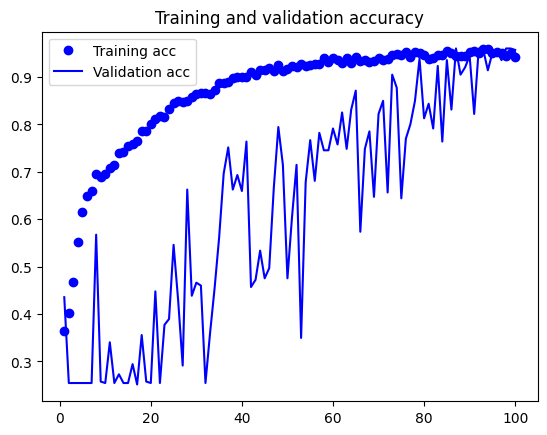

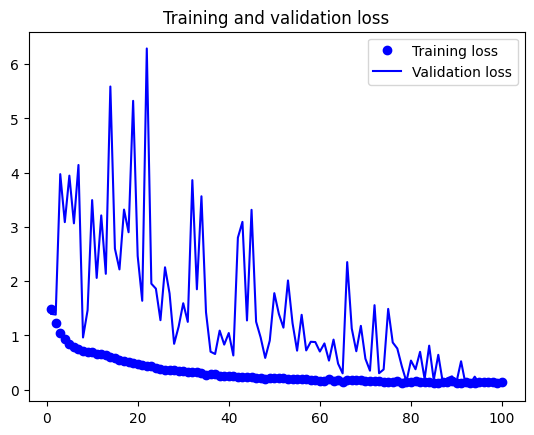

In [17]:
import matplotlib.pyplot as plt

# Extract the history from the training process
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot the training and validation accuracy
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# Plot the training and validation loss
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Evaluate the model

In [18]:
# Train accuracy and loss
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f'Train accuracy: {train_accuracy*100:.4f}%')
print(f'Train loss: {train_loss:.4f}')
print()

# Test accuracy and loss
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy: {test_accuracy*100:.4f}%')
print(f'Test loss: {test_loss:.4f}')
print()

# Validation accuracy and loss
validation_loss, validation_accuracy = model.evaluate(X_validation, y_validation, verbose=0)
print(f'Validation accuracy: {validation_accuracy*100:.4f}%')
print(f'Validation loss: {validation_loss:.4f}')

Train accuracy: 99.0092%
Train loss: 0.0304

Test accuracy: 96.3145%
Test loss: 0.1080

Validation accuracy: 95.7055%
Validation loss: 0.1043


## Confusion Matrix

26/26 [==============================] - 2s 5ms/step
[[195   2   9]
 [  2 239  13]
 [  1   3 350]]


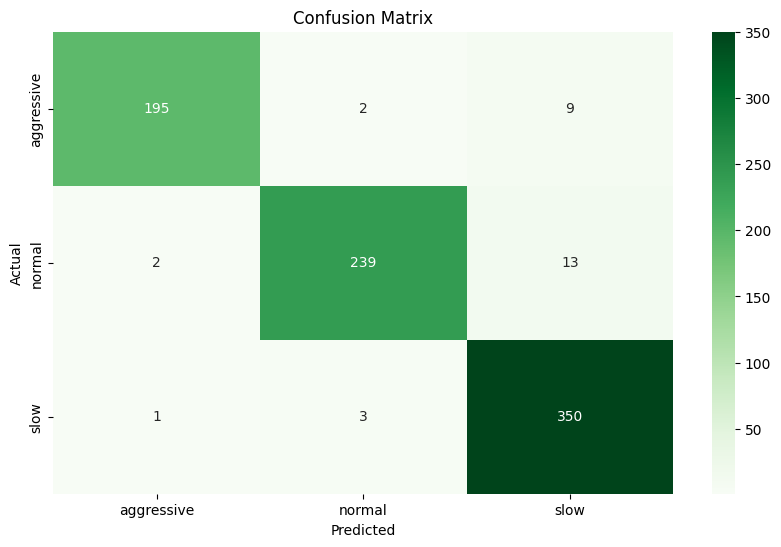

In [19]:
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

# Simple confusion matrix
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)


conf_matrix = metrics.confusion_matrix(y_test, pred)
print(conf_matrix)

# Graphical confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, pred)

plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## PCE and MPCE


- **Per-Class Error (PCE)** $\large = \text{1 - \ Class Accuracy }$

- **Mean Per-Class Error (MPCE)** $\large = \frac{1}{k} \sum \text{PCE}$

Mean per-class error (MCPE): 0.04125

'aggressive'
Per-class Error (PCE): 0.05340
Per-class Accuracy (PCA): 0.94660

'normal'
Per-class Error (PCE): 0.05906
Per-class Accuracy (PCA): 0.94094

'slow'
Per-class Error (PCE): 0.01130
Per-class Accuracy (PCA): 0.98870



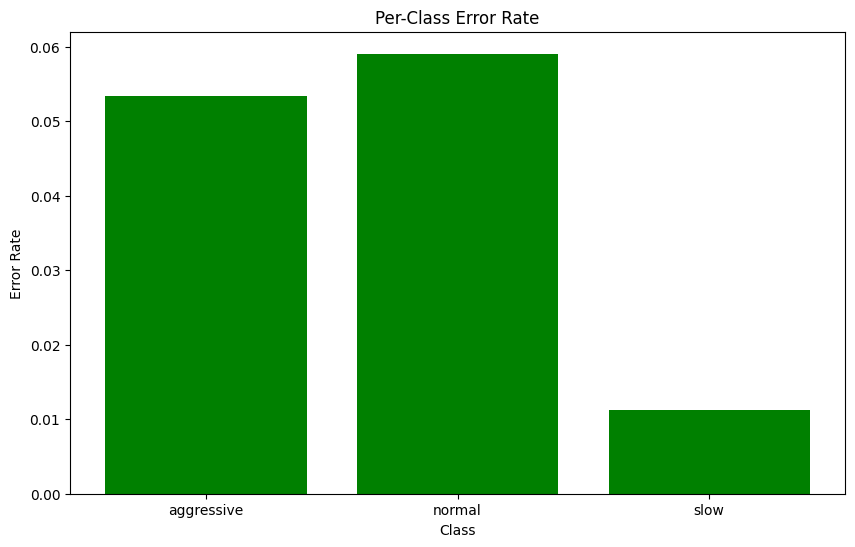

In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, pred)

# Calculate per-class accuracy
per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Convert per-class accuracy to per-class error
per_class_error = 1 - per_class_accuracy

# Mean per-class error
mean_per_class_error = np.mean(per_class_error)
print(f"Mean per-class error (MCPE): {mean_per_class_error:.5f}")
print()

# Display per-class error
for idx, class_name in enumerate(label_names):
    print(f"'{class_name}'")
    print(f"Per-class Error (PCE): {per_class_error[idx]:.5f}")
    print(f"Per-class Accuracy (PCA): {per_class_accuracy[idx]:.5f}")
    print()
    

plt.figure(figsize=(10, 6))
plt.bar(label_names, per_class_error, color='green')
plt.xlabel('Class')
plt.ylabel('Error Rate')
plt.title('Per-Class Error Rate')
plt.show()























## Performance Metrics

- Accuracy  $\large = \frac{Correct~Predictions}{All~Predictions}$
- Precision for a given class  $\large = \frac{Correct~Predictions~for~the~Class}{All~Predictions~for~the~Class}$   
- Recall for a given class  $\large = \frac{Correct~Predictions~for~the~Class}{All~Instances~of~the~Class}$  
- F1 Score $\large = \frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$  
- Hamming Loss $\large = \frac{1}{N} \sum_{i=1}^{N} \frac{\text{Incorrect Labels}}{\text{Total Labels}}$  
- Jaccard Score $\large = \frac{|Y_{pred} \cap Y_{true}|}{|Y_{pred} \cup Y_{true}|}$  



- Averaging is a way to get a single number for multiclass. Depending on the importance one wants to give to minority classes: 
    - Macro average: Compute the metric for each class, and returns the average without considering the proportion for each class in the dataset. For instance:

        Precision = $\large = \frac{P_{class 1} ~+~ P_{class 2} ~+~ ... ~+~ P_{class n}}{N}$   
    
    - Weighted average: Compute the metric for each class, and returns the average considering the proportion (weighted) for each class in the dataset. For instance:

        Precision = $\large = \frac{N_1 ~*~ P_{class 1} ~+~ N_2 ~*~ P_{class 2} ~+~ ... ~+~ N_n ~*~ P_{class n}}{N}$

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculates performance metrics
acc = accuracy_score(y_true =  y_test, y_pred = pred)
print(f'Accuracy : {np.round(acc*100,2)}%')

print()
          
precision = precision_score(y_true =  y_test, y_pred = pred, average='macro')
print(f'Precision - Macro: {np.round(precision*100,2)}%')

recall = recall_score(y_true =  y_test, y_pred = pred, average='macro')
print(f'Recall - Macro: {np.round(recall*100,2)}%')

f1 = f1_score(y_true =  y_test, y_pred = pred, average='macro')
print(f'F1-score - Macro: {np.round(f1*100,2)}%')

print()

precision = precision_score(y_true =  y_test, y_pred = pred, average='weighted')
print(f'Precision - Weighted: {np.round(precision*100,2)}%')

recall = recall_score(y_true =  y_test, y_pred = pred, average='weighted')
print(f'Recall - Weighted: {np.round(recall*100,2)}%')

f1 = f1_score(y_true =  y_test, y_pred = pred, average='weighted')
print(f'F1-score - Weighted: {np.round(f1*100,2)}%')

Accuracy : 96.31%

Precision - Macro: 96.84%
Recall - Macro: 95.87%
F1-score - Macro: 96.31%

Precision - Weighted: 96.41%
Recall - Weighted: 96.31%
F1-score - Weighted: 96.31%


## Classification report

Detailed summary of the classification model's performance across different classes.

In [22]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred, target_names=label_names))

              precision    recall  f1-score   support

  aggressive       0.98      0.95      0.97       206
      normal       0.98      0.94      0.96       254
        slow       0.94      0.99      0.96       354

    accuracy                           0.96       814
   macro avg       0.97      0.96      0.96       814
weighted avg       0.96      0.96      0.96       814

